# 14. 폐렴아 기다려라!

## 목차
- 의료영상에 대해  
- X-RAY 이미지  
- 폐렴을 진단해보자!      
- 직접 해보는 폐렴진단  

# 14. 프로젝트 : 폐렴 진단기 성능개선

우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서,  

어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.

In [24]:
import re    
import os    
import pandas as pd    
import numpy as np     
import tensorflow as tf  
import matplotlib.pyplot as plt   
from sklearn.model_selection import train_test_split  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 50

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

# ModelCheckpoint
mc = ModelCheckpoint(filepath='./model.h5',
                     monitor='val_accuracy',
                    save_best_only=True,
                    verbose=1,
                    )

print(ROOT_PATH)

/home/aiffel-dj56/aiffel


## Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [26]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [27]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 50

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

# ModelCheckpoint
mc = ModelCheckpoint(filepath='./model.h5',
                     monitor='val_accuracy',
                    save_best_only=True,
                    verbose=1,
                    )

print(ROOT_PATH)

/home/aiffel-dj56/aiffel


## Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [28]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print("train : ",len(train_filenames), "개")
print("test : ", len(test_filenames), "개")
print("val : ", len(val_filenames), "개")

#val 개수 부족

train :  5216 개
test :  624 개
val :  16 개


In [29]:
# PNEUMONIA와 NORMAL로 구별됨
train_filenames[0]

'/home/aiffel-dj56/aiffel/chest_xray/train/PNEUMONIA/person402_bacteria_1813.jpeg'

In [30]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print("train : ", len(train_filenames))
print("val : ", len(val_filenames))

train :  4185
val :  1047


In [31]:
# PNEUMONIA와 NORMAL로 구별됨
train_filenames[0]

'/home/aiffel-dj56/aiffel/chest_xray/train/PNEUMONIA/person22_bacteria_74.jpeg'

## 데이터의 클래스 불균형(imbalance)
- 정상보다 폐렴 이미지수가 3배가 더 많기 때문에 학습이 잘 진행되지 않음
- CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 training 잘됨

## Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [32]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1105
Pneumonia images count in training set: 3080


In [33]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [34]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [35]:
#클래스 라벨 확인
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [36]:
#label 추출
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [37]:
#이미지 -> tensor변환 -> resize
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

In [38]:
#라벨 추출하고 이미지 읽고, tensor변환, resize
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [39]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [40]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [41]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 파이프라인 완성시키기
- 위에서 만들어 놓은 ```train_ds```, ```test_ds```를 완성시킨다.
- ```augment```함수
    - augmentation을 적용할 때는 좌우 반전만 적용한다.
    - 의료영상의 경우, 일반적인 이미지처리에서 사용하는 augmentation들은 성능 향상에 도움이 된다고 말할 수 없다.
    - X-RAY와 같은 의료영상의 특성상 오히려 noise가 되어서 방해를 할 수도 있기 때문
    - 이러한 점에서 오히려 **GAN**을 통해서 새로운 의료영상을 생성해내고 이렇게 생성한 데이터는 개인정보 노출에 대한 위험도 없다고 한다.
- ```prepare_for_training``` 함수
    - augmentation을 수행할지 안할지 bool형 변수 ```aug```를 받고 입력되는 데이터셋에 다음과 같은 작업을 수행한다.
        1. augment함수 적용 여부
        2. suffle
        3. reapeat
        4. batch
        5. prefetch

In [42]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

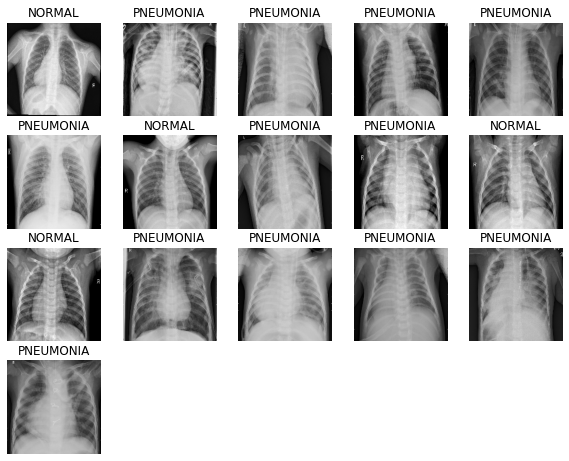

In [43]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

### SeparableConv2D??
---
- Depthwise Separable Convolution : 깊이별 분리 합성곱
- 입력 채널별로 따로따로 공간의 합성곱을 수행 (```SeparableConv2D```)
- 공간 특성과 채널 방향 특성을 독립적으로 인식하여 학습하고, 모델 파라미터와 연산수를 줄인다 = 더 빠르고 효율적인 학습
- **제한된 데이터로 작은 모델을 처음부터 훈련시킬 때 특히 더 중요**

In [44]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D()
    ]
    )
    
    return block

In [45]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [46]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.SeparableConv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        
        conv_block(64),
        conv_block(64),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.summary()
    
    return model

In [47]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.89
Weight for class 1: 0.68


## Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [48]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_8 (Separabl (None, 180, 180, 16)      91        
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 180, 180, 16)      416       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 64)        9728      
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 64)      

In [49]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es, mc]
    )

Epoch 1/50
261/261 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.6674 - precision: 0.8684 - recall: 0.6461
Epoch 00001: val_accuracy improved from -inf to 0.82404, saving model to ./model.h5
261/261 [==============================] - 32s 123ms/step - loss: 0.6100 - accuracy: 0.6674 - precision: 0.8684 - recall: 0.6461 - val_loss: 0.3837 - val_accuracy: 0.8240 - val_precision: 0.8578 - val_recall: 0.9235
Epoch 2/50
261/261 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8705 - precision: 0.9597 - recall: 0.8602
Epoch 00002: val_accuracy did not improve from 0.82404
261/261 [==============================] - 29s 112ms/step - loss: 0.3180 - accuracy: 0.8705 - precision: 0.9597 - recall: 0.8602 - val_loss: 0.5864 - val_accuracy: 0.7740 - val_precision: 0.7725 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9040 - precision: 0.9684 - recall: 0.8986
Epoch 00003: val_accuracy did 

Epoch 21/50
261/261 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9279 - precision: 0.9786 - recall: 0.9222
Epoch 00021: val_accuracy did not improve from 0.96923
261/261 [==============================] - 31s 120ms/step - loss: 0.2020 - accuracy: 0.9279 - precision: 0.9786 - recall: 0.9222 - val_loss: 0.1286 - val_accuracy: 0.9587 - val_precision: 0.9909 - val_recall: 0.9548
Epoch 22/50
261/261 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9478 - precision: 0.9834 - recall: 0.9451
Epoch 00022: val_accuracy did not improve from 0.96923
261/261 [==============================] - 32s 124ms/step - loss: 0.1541 - accuracy: 0.9478 - precision: 0.9834 - recall: 0.9451 - val_loss: 0.1470 - val_accuracy: 0.9510 - val_precision: 0.9870 - val_recall: 0.9487
Epoch 23/50
261/261 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9480 - precision: 0.9818 - recall: 0.9469
Epoch 00023: val_accuracy did not improve from 0.96923
2

## Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

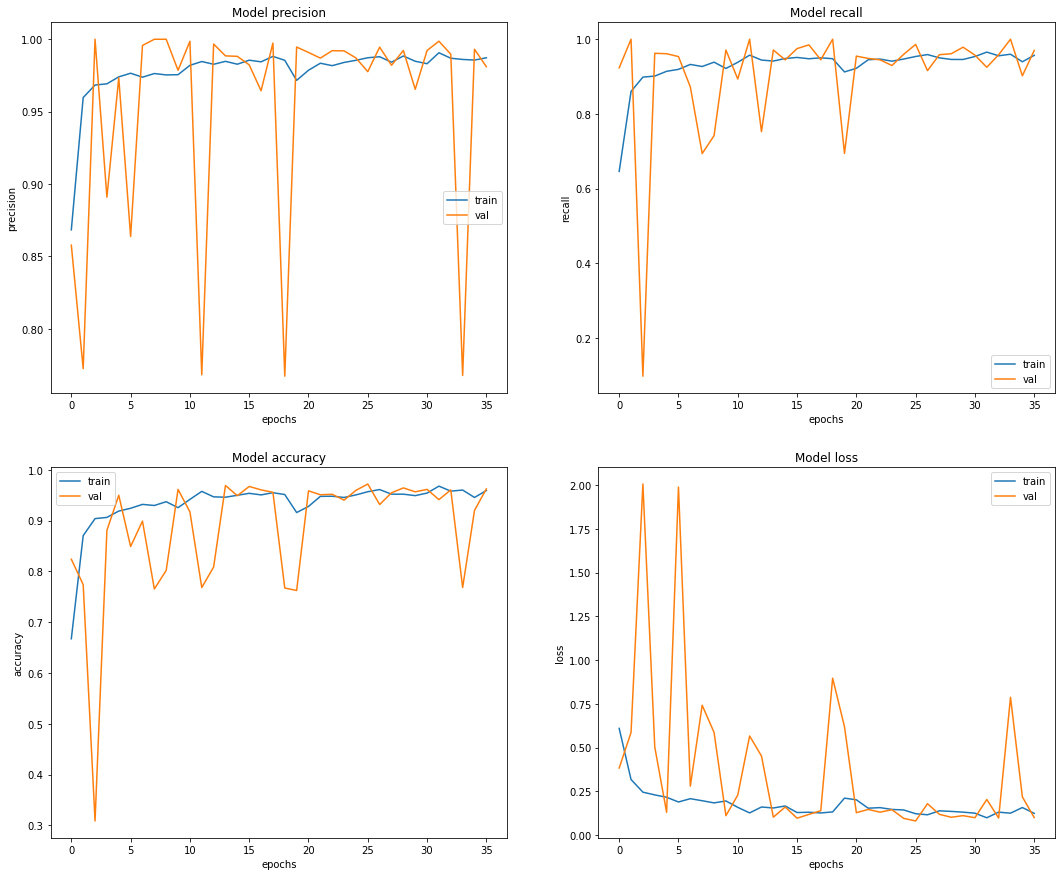

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(18, 15))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
new_model = tf.keras.models.load_model('./model.h5')

In [52]:
loss, acc, prec, rec = new_model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.8629 - accuracy: 0.7612 - precision: 0.7236 - recall: 1.0000


# 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항/상세기준
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.


2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.


3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
Accuracy 기준 85%에 도달하였다.

# 결과 & 고찰

의료용 이미지를 처음 처리해 보면서 인간의 실수로 잘못 판단되어 발생하는 의료사고가 더이상 생기기 않을 수 있지 않을까에 대한 기대와 함께 인공지능으로 병변을 판단한다는 것이 인간보다 나은 대응 능력이 될 수 있는지에 대한 의문이 함께 들었다. 

초반에 배웠단 '정밀도(precision)', '재현율(recall)', '정확도(accuracy)', '손실률(loss)'을 모델 학습 결과 다시 점검해 보면서 각각의 의미를 되세겨 볼 수 있었다.

병이 양성일 때 양성으로 판단해야 하는 것이 더욱 중요하기 때문에 재현율(recall)이 더 중요하기 때문에 높은 값이 나와야 한다는 점을 이번 과제를 통해서 연습해 볼 수 있었다. 그러나, 모델의 결과값에서 폐렴과 정상의 비율이 너무나도 불균형했기 때문에 다른 결과에 비해서 재현율, 민간도(recall)의 결과값이 1에 가까운 결과에 도달한 것으로 생각되었다.

과제 상의 모델이 훌륭해서 좋은 결과가 나온 것이 없다면 좋았겠지만... 우리가 가지고 있는 학습 데이터의 문제라고 판단이 되었다. 

conv_block을 32->64->128로 늘려서 실행해보고, Conv2D layer에 추가하여 변경하여 실행하여 85%로 도달하도록 노력해 보았다. 